# Content Moderation and Toxicity Classification using LSTMs

After exploring the hybrid approach with SGD and Naive Bayes, our next effort in the **Jigsaw Toxic Comment Classification Dataset** involves implementing Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN).

**LSTM:** It is well-suited for sequence prediction tasks, where context plays a crucial role in understanding the meaning. LSTMs excel at capturing long-term dependencies, allowing them to remember information for extended periods. This makes them ideal for analysing the sequential nature of text data, capturing the nuances and dependencies in the language that are critical for effective toxicity classification.

**Imports**

In [223]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
import nltk
nltk.download('stopwords')
import inflect
import re
import torch
import string

!pip install contractions
import contractions
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, hamming_loss
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Embedding, Dense, Bidirectional,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, CategoricalAccuracy, Recall

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparing Data

**1. Loading dataset**

We begin by loading the dataset. This dataset will then be used for training and testing. It includes user-generated comments with labels indicating various types of toxicity.


In [153]:
data = pd.read_csv('/content/drive/MyDrive/ML Proj/Dataset/Train/train.csv')

data = data.drop(columns = ['id'])

data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**2. Analyzing Label Distribution in the Dataset**

The cell output indicates the distribution of labels in the dataset. It shows the total count of each label within the dataset, providing a clear indication of class imbalance, with 'toxic' being the most common label and 'threat' being the least common. This imbalance can affect the performance of machine learning models, as they tend to be better at detecting the majority class while struggling with minority classes.

Models trained on this dataset may develop a bias towards more frequently occurring labels, which can lead to **higher precision and recall** for those labels as compared to less frequent ones.

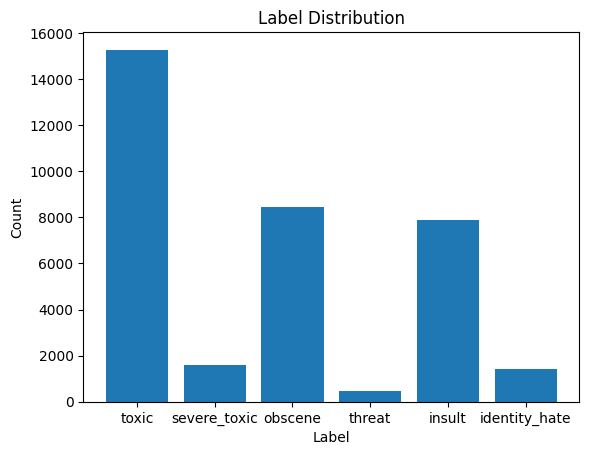

In [154]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_count = data.iloc[:,1:].sum()

plt.bar(labels,label_count)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**3. Pre-processing of comments**

This function preprocess the text data from the Jigsaw Toxic Comment Classification Dataset.


*   **Removing Non-ASCII characters:** Removes non-ASCII characters to simplify text, and focus on English language words
*   **Expanding Contractions:** Replaces contraction like "can't" to "can not" for clarity and to mantain consistency
*   **Removing URLs:** Removes URLs starting with 'https', 'www'
*   **Removing Punctuations:** Remove punctuation marks from the comments as mostly they are irrelevant for the classifcation problem
*   **Removing Numbers:** Removes numbers as they aren't relevant in this classification problem
*   **Removing Stop Words:** Filters out stop words like "is", "the" and etc. These words occur frequently and offer little value for analysis

By performing these pre-processing steps, we create a cleaner and more standardized dataset that can help improve the performance of our classification models. Each step is aimed at reducing the complexity of the text data, which can lead to more efficient and effective learning by the models we use. This pre-processed data should help the model to focus on the textual patterns most relevant to identifying different forms of toxicity in online comments.

In [155]:
stop_words = set(stopwords.words('english'))

def pre_process_comments(data):
    processed_data = []

    # for idx in tqdm(range(len(data))):
    for idx in range(len(data)):
        comment = data[idx]

        # removing non-ascii characters
        comment = comment.encode('ascii', 'ignore').decode('ascii')

        # expanding contractions
        comment = contractions.fix(comment)

        # removing URLs
        comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)

        # removing HTML tags
        comment = re.sub(r'<[^>]+>', '', comment)

        # removing punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # removing numbers
        comment = re.sub(r'\d+', '', comment)

        # tokenizing the words
        tokens = comment.split()

        # removing stop words and numbers
        tokens = [word for word in tokens if word not in stop_words]

        comment = ' '.join(tokens)

        processed_data.append(comment)

    return processed_data

# Analysis of Comment Lengths for LSTM Sequence Length Determination

In this cell, we look into maximum and minimum length for the comments in our dataset.

Our goal is to select a sequence length that captures the essence of most comments without truncating too much information.

We notice that a significant number of comments have over 72 characters, setting a sequence length just above this threshold might be a good starting point.

In [156]:
comment_lengths = []

for comment in data['comment_text']:
    comment_lengths.append(len(comment))

print('Min Comment Length:', min(comment_lengths))
print('Max Comment Length:', max(comment_lengths))
sum([1 for i in range(len(comment_lengths)) if comment_lengths[i] >= 72])

Min Comment Length: 6
Max Comment Length: 5000


130957

**4. Splitting Data into Training, Validation, and Test Sets (80:10:10)**

Proper data splitting is essential for training robust machine learning models, allowing us to assess their performance and generalize to unseen data effectively.

In [157]:
data_comp = np.asarray(data.iloc[:,0])
labels_comp = np.asarray(data.iloc[:,1:])

X_train, X_temp, y_train, y_temp = train_test_split(data_comp, labels_comp, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (127656,)
Training labels shape: (127656, 6)
Validation data shape: (15957,)
Validation labels shape: (15957, 6)
Test data shape: (15958,)
Test labels shape: (15958, 6)


**4. Tokenization and Vectorization for LSTM**

In this cell, we tokenize the dataset, and then vectorize it to make it suitable for processing by a LSTM model. This step is critical to reduce noise and normalize the text data for better model performance.


1.   **Pre-processing**: pre_process_comments cleans the text
2.   **Tokenization + Vectorization**: we add special tokens for beginning and end of sentence

**Tokenization and Vectorization Details:**



*   The BERT tokenizer adds special tokens [CLS] at the start and [SEP] at the end of sentence.
*   We have set max length to 72 due to time/ memory constraints. It ensures that all tokenized outputs are padded or truncated to a consistent length, which is necessary for batching in the BERT model.


By completing these tokenization and vectoriztion steps, we ensure that our dataset is in consistent and numerical format for the LSTM model, which can lead to better understanding and performance on the classification task. This process contributes significantly to the model's ability to accurately predict the various toxicity levels in the Jigsaw Toxic Comment Classification Dataset.

Moreover, the fixed sequence length and the comprehensive vocabulary coverage are particularly important for capturing the contextual nuances essential for effective content moderation.






In [158]:
def tokenize_data(vectorizer, data, labels, max_length=100):
    # Preprocess the data
    data = pre_process_comments(data)

    # Vectorize the data using the provided TextVectorization layer
    vectorized_data = vectorizer(data)

    # Ensure the vectorized data has a consistent shape
    vectorized_data = tf.keras.preprocessing.sequence.pad_sequences(vectorized_data,
                                                                    maxlen=max_length,
                                                                    padding='post',
                                                                    truncating='post')

    # Convert labels to a tensor
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    return vectorized_data, labels


# Initializing the Vectorizer and LSTM Model for Sequence Classification

In this section, we initialize Text Vectorizer and model, setting them up for our multi-label classification problem

We've set max tokens to 100000, so that the vectorizer have a vocabulary of the top 100,000 most common words.

Next, we construct the LSTM model. The architecture is defined in the subsequent cells.

We're now left with the task to fine tune the model on our dataset, where the labels are not mutually exclusive and reflective of real-world conditions where a comment might exhibit multiple forms of toxicity.

In [159]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

num_labels = 6

# vectorizer
vectorizer = TextVectorization(max_tokens = 100000, output_sequence_length = 100, output_mode='int')
vectorizer.adapt(X_train)

# model
model = Sequential([
    Embedding(100000+1, 32, input_length = 100),
    Bidirectional(LSTM(32,activation = 'tanh')),
    Dense(128,activation='relu'),
    Dense(num_labels,activation = 'sigmoid')
])

**Model Architecture**

In [160]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 32)           3200032   
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                16640     
 ional)                                                          
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 6)                 774       
                                                                 
Total params: 3225766 (12.31 MB)
Trainable params: 3225766 (12.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Vectorizing the Dataset for BERT Model Input**

In [161]:
# Vectorize the training set
train_input, train_labels = tokenize_data(vectorizer, X_train, y_train)

# Vectorize the validtaion set
val_input, val_labels = tokenize_data(vectorizer, X_val, y_val)

# Vectorize the test set
test_input, test_labels = tokenize_data(vectorizer, X_test, y_test)

# Creating DataLoaders for Training, Validation, and Testing



*   **TensorDataset**

    Combines the input features and labels into a single dataset, which simplifies the data handling process. By doing this, we ensure that our input data and labels are aligned and can be easily batched and loaded during model training and evaluation.
    
*   **DataLoader** is a pytorch utility which allows for efficient batch processing

The use of DataLoaders facilitates efficient batch processing, which is particularly important for the fine-tuning phase.


In [162]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 64

train_loader = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_loader = val_dataset.batch(BATCH_SIZE)
test_loader = test_dataset.batch(BATCH_SIZE)

# Inspecting a Batch of Preprocessed Data from the Training DataLoader

In this cell we extract and inspect an individual batch of data from the DataLoader. It details the batch size, the shape of input IDs, and shows an example of the encoded text, its decoded version, attention masks, and labels for one instance.

In [163]:
Batch = next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
input_ids = Batch[0][0].numpy().tolist()
vocabulary = vectorizer.get_vocabulary()
decoded_text = ' '.join([vocabulary[id] for id in input_ids if id < len(vocabulary)])
print('Decoded Input ids :\n', decoded_text)
print('Corresponding Label:',Batch[1][0])

Each Input ids shape : (64, 100)
Input ids :
 tf.Tensor(
[  16  967   88   72 1390  158   24    1  306 2865 1953   23   72  180
  676  158  659  306   24   46  447   88   72   45   29 2117    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32)
Decoded Input ids :
 on april did know updated fact article [UNK] created substantially expanded if know another interesting fact recently created article please suggest did know talk page chat                                                                          
Corresponding Label: tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)



# Calculating the Total Number of Batches in the Training DataLoader


In [164]:
total_samples = len(train_dataset)  # Total number of samples in the dataset
batch_size = len(train_loader)  # Batch size used in DataLoader
expected_batches = total_samples / batch_size  # Expected number of batches

print(f"Total samples: {total_samples}")
print(f"Batch size: {batch_size}")
print(f"Expected number of training batches: {int(expected_batches)}")

Total samples: 127656
Batch size: 1995
Expected number of training batches: 63


# Setting Up the Loss Function and Optimizer for LSTM Model Training

*   **Adam Optimizer:** We chose the Adam optimizer because of its efficiency in handling sparse gradients and adaptability in various learning scenarios.
*   **Binary Cross Entropy Loss:** This loss function is ideal for multi-label classification tasks, where each label is independent and not mutually exclusive.

In [165]:
import torch as nn
from torch.nn import BCEWithLogitsLoss
from tensorflow.keras.optimizers import Adam

loss_fn = BCEWithLogitsLoss()
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'BinaryCrossentropy', metrics=['accuracy'])

In [166]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Training and Validation for Fine-Tuning the LSTM model

This cell contains the training and validation loop for fine-tuning the LSTM model on our multi-label classification task. It iterates over the dataset for a set number of epochs, updating the model parameters based on the training data and evaluating the model's performance on the validation data on a regular basis.

To balance training Time and model performance, we choose to do **three** iterations only. More epochs can lead to overfitting, especially if the training dataset is like our's - imbalanced. This approach is particularly effective in the exploratory phases of model development, where the goal is to understand the model's behavior and potential rather than fully optimizing its performance.

In [167]:
def train(model, train_dataset, val_dataset, num_epochs):
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )
    return history


history = train(model, train_loader, val_loader, num_epochs = 3)

# To access the training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# To access the training and validation accuracies
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']


Epoch 1/3
1995/1995 [==============================] - 88s 42ms/step - loss: 0.0723 - accuracy: 0.9855 - val_loss: 0.0503 - val_accuracy: 0.9930
Epoch 2/3
1995/1995 [==============================] - 34s 17ms/step - loss: 0.0433 - accuracy: 0.9938 - val_loss: 0.0536 - val_accuracy: 0.9930
Epoch 3/3
1995/1995 [==============================] - 30s 15ms/step - loss: 0.0375 - accuracy: 0.9920 - val_loss: 0.0545 - val_accuracy: 0.9919


# Plotting Losses over Epochs

In this cell, we visually represnt the training loss of the LSTM model across the epochs.

The plot shows a downward trend, indicating that the model's loss is decreasing over time and thus learning from the training data

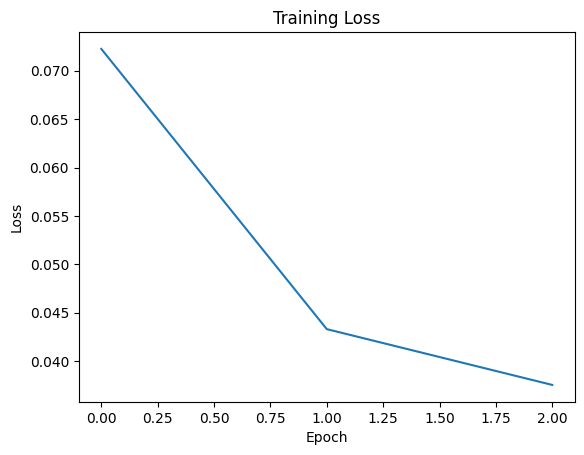

In [168]:
# plot train losses
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluation

We're now done with the training part. To evaluate its performace, we will use test data to make predictions, and compare these predictions to the actual labels. It helps in understanding how well the model generalizes to unseen data.
The evaluation metrics we will use are:

**Accuracy:** To measure how often the model predicts the correct labels across all classes.

**Binary Cross Entropy Loss:** To account for the proportion of misclassified labels, which is important in multi-label classification tasks.

**Classification Report:** To get detailed insights into the precision, recall, and F1-score for each individual label, which helps us understand the model's strengths and weaknesses for each type of label..

In [169]:
y_pred_continuous = model.predict(test_input)
y_pred = np.where(y_pred_continuous > 0.5, 1, 0)
test_labels = np.array(test_labels)
accuracy = accuracy_score(test_labels, y_pred)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

ham_loss = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {ham_loss}")

# Generate a classification report for detailed metrics
class_report = classification_report(test_labels, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], zero_division=0)
print(class_report)

499/499 [==============================] - 3s 4ms/step
Accuracy: 0.9162802356184986
               precision    recall  f1-score   support

        toxic       0.81      0.75      0.78      1520
 severe_toxic       0.45      0.37      0.41       162
      obscene       0.83      0.76      0.79       856
       threat       0.00      0.00      0.00        37
       insult       0.77      0.63      0.69       808
identity_hate       0.25      0.02      0.04       138

    micro avg       0.79      0.67      0.73      3521
    macro avg       0.52      0.42      0.45      3521
 weighted avg       0.76      0.67      0.71      3521
  samples avg       0.07      0.06      0.06      3521



In [224]:
y_pred_continuous = model.predict(test_input)
y_pred = np.where(y_pred_continuous > 0.5, 1, 0)
test_labels = np.array(test_labels)
accuracy = accuracy_score(test_labels, y_pred)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

ham_loss = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {ham_loss}")

# Generate a classification report for detailed metrics
class_report = classification_report(test_labels, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], zero_division=0)
print(class_report)

499/499 [==============================] - 2s 5ms/step
Accuracy: 0.9162802356184986
Hamming Loss: 0.018674019300664244
               precision    recall  f1-score   support

        toxic       0.81      0.75      0.78      1520
 severe_toxic       0.45      0.37      0.41       162
      obscene       0.83      0.76      0.79       856
       threat       0.00      0.00      0.00        37
       insult       0.77      0.63      0.69       808
identity_hate       0.25      0.02      0.04       138

    micro avg       0.79      0.67      0.73      3521
    macro avg       0.52      0.42      0.45      3521
 weighted avg       0.76      0.67      0.71      3521
  samples avg       0.07      0.06      0.06      3521



**Model Perfomance Analysis:**

The model has a overall accuracy of 91.6%, suggesting that the model performs well for the majority of predictions. However, examining the recall values, especially for less represented classes such as 'threat' and 'identity_hate', reveals that the model struggles to identify these rarer cases. While accuracy is a useful indicator, it does not always provide the full picture, especially in an imbalanced dataset. Therefore, we delve deeper into the precision, recall, and F1-scores to gauge the model's performance across individual classes.

For toxic comments, f1-score is 0.78, which vows for high precision and recall. Despite, precision of 0.45, severe_toxic label have a very low recall. This suggests that while the model is relatively confident when it identifies a comment as severely toxic, it misses a significant number of such instances. For the obscene class, we see a high precision of 0.83 and fairly good recall of 0.76. Thus, our model seems to perform well in identifying obscene content. The threat class shows a significant issue, with both precision and recall at 0.00. This means the model failed to correctly identify any true positives in this category. This is due to the low number of samples for this class in the dataset. For the other classes the model performs moderately.

Low recall values suggests that model is failing to identify a significant portion of the minority classes. This can be attributed to the fact that our dataset is **imbalanced**. This results in minority classes being not adequately learned by the model, leading to more false negatives.

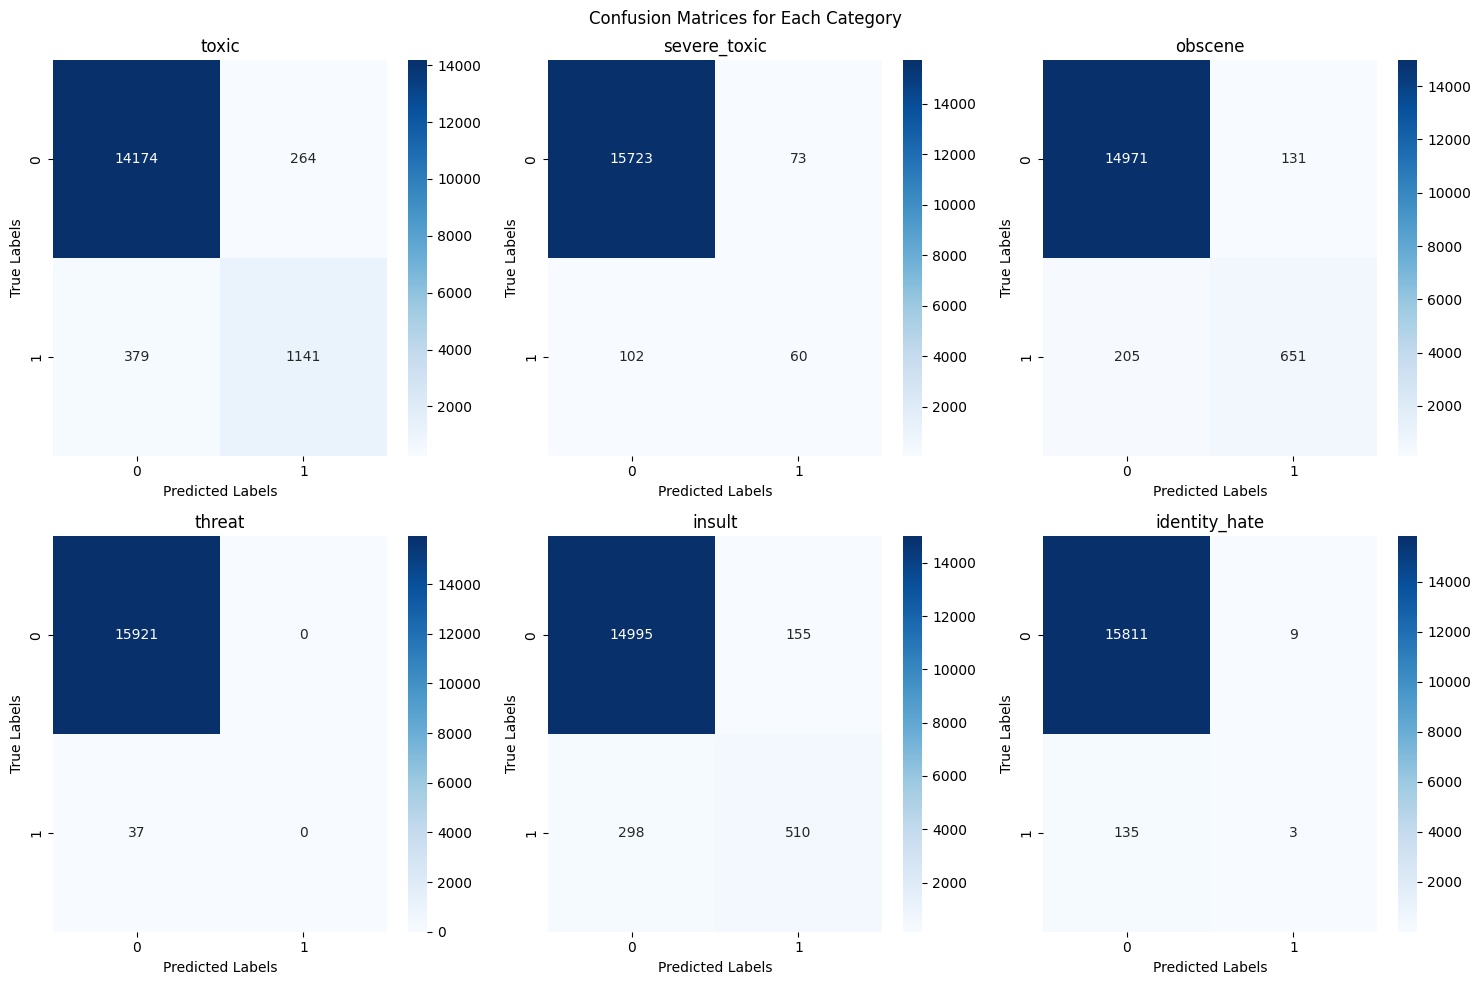

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels as numpy arrays
y_true = test_labels
y_pred = np.array(y_pred)

# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plotting each confusion matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the layout based on your preference
fig.suptitle('Confusion Matrices for Each Category')

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i, cm in enumerate(confusion_matrices):
    ax = axes.flatten()[i]
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(label_names[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Text Classification with the Trained Model

In this final section, we will use our trained model to classify new input text. This involves several key steps:



1.   Pre-processing the input
2.   Transforming text to features (Vectorization)
3. Model Prediction
4. Interpretation of the output

In [209]:
def predict_input(text, model, vectorizer, threshold=0.5):
    # Step 1: Pre-processing the input
    preprocessed_text = pre_process_comments([text])  # Assuming pre_process_comments is your custom preprocessing function

    # Step 2: Transforming text to features
    vectorized_text = vectorizer(preprocessed_text)
    vectorized_text = tf.keras.preprocessing.sequence.pad_sequences(vectorized_text, padding='post', maxlen=100)

    # Step 3: Model Prediction
    prediction_probs = model.predict(vectorized_text)

    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    predicted_labels = [label for label, pred in zip(labels, prediction_probs[0]) if pred > 0.5]

    return predicted_labels

In [219]:
input_text = "Fat man go eat with your nigga brother"
predicted_labels = predict_input(input_text, model, vectorizer)
print("Predicted labels:", predicted_labels)

1/1 [==============================] - 0s 29ms/step
Predicted labels: ['toxic', 'obscene', 'insult']


In [211]:
input_text = "I'll blow you and the tower with guns"
predicted_labels = predict_input(input_text, model, vectorizer)
print("Predicted labels:", predicted_labels)

1/1 [==============================] - 0s 20ms/step
Predicted labels: []


This output is as expected. The model is unable to classify 'threat, which is evident from the classification report.

In [221]:
input_txt = "i will kill you nigger retard jew fuck ass blast bomb"
predicted_labels = predict_input(input_text, model, vectorizer)
print("Predicted labels:", predicted_labels)

1/1 [==============================] - 0s 148ms/step
Predicted labels: ['toxic', 'obscene', 'insult']


The model is unable to categorise 'identity_hate' as well, even though 'Jew' was present, which is quite common in the dataset.